In [183]:
import pandas as pd
import numpy as np
import itertools as it
from collections import OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle

from scipy.stats import gaussian_kde
from Bio import SeqIO

In [184]:
all_nodes = pd.read_csv('data/dbgwas/dbgwas_output/textualOutput/all_comps_nodes_info.tsv',
                        sep='\t')
all_nodes.reset_index(inplace=True)
all_nodes.drop('Annotations(sep=~~~)', inplace=True, axis=1)
all_nodes.columns = ['CompId', 'NodeId', 'AlleleFreq', 'Pheno0Count',
       'Pheno0TotalCount', 'Pheno1Count', 'Pheno1TotalCount', 'NACount',
       'NATotalCount', 'Significant?', 'p-value', 'q-Value', 'EstEffect',
       'WaldStat', 'Sequence', 'SequenceLength', 'Annotations(sep=~~~)']

sig_nodes = all_nodes[all_nodes['Significant?'] == 'Yes'].reset_index()
sig_nodes.loc[:, 'Annotations(sep=~~~)'] = sig_nodes['Annotations(sep=~~~)'].fillna("No Annotation")
sig_nodes.shape

(691, 18)

In [185]:
%%time
def matching(r):
    return not set(['n' + str(i) for i in r.split()]).isdisjoint(sig_nodes.NodeId.values)
row_maps = 'data/dbgwas/dbgwas_output/step1/bugwas_input.unique_rows_to_all_rows.binary'
with open(row_maps) as rmaps:
    mapped = dict([(idx, row.strip()) for idx, row in enumerate(rmaps.readlines())\
                   if matching(row)])
row_gen = 'data/dbgwas/dbgwas_output/step1/bugwas_input.unique_rows.binary'
with open(row_gen) as rg:
    _ = rg.readline() # skip header
    rowlines = [i.strip() for i in rg.readlines() if int(i.split()[0]) in mapped.keys()]

weight_file = 'data/dbgwas/dbgwas_output/step1/weight_correction'
with open(weight_file) as wf:
    major_allele = [bool(int(i.replace('-1','0'))) for n, i in enumerate(wf.readlines()) if n in mapped.keys()]

CPU times: user 8.29 s, sys: 146 ms, total: 8.43 s
Wall time: 8.43 s


In [186]:
ntg = pd.DataFrame([i.split() for i in rowlines]).set_index(0, drop=True).astype(int)
ntg.index = ntg.index.astype(int)
rename = dict([(i, int(mapped[i].split()[0])) for i in mapped])

assert(len([i for i in ntg.index if i not in rename]) == 0)
ntg = ntg.rename(index=rename)

# ntg.index = ntg.index.astype(int)
alt_ntg = pd.DataFrame(np.bitwise_xor(ntg.T.values.astype(bool), True).T,
                      columns=ntg.columns, index=ntg.index).astype(int)
for idx, row in ntg.iterrows():
    s = ntg.loc[idx].sum()
    s2 = sig_nodes[sig_nodes.NodeId == 'n' + str(idx)]['AlleleFreq'].values[0]
    if s - s2 != 0:
        ntg.loc[idx] = alt_ntg.loc[idx]

In [187]:
diff = []
for i in ntg.index:
    s = ntg.loc[i].sum()
    s2 = sig_nodes[sig_nodes.NodeId == 'n' + str(i)]['AlleleFreq'].values[0]
    diff.append(s-s2)
assert(not any(diff))

In [195]:
kmer_md = pd.read_csv('data/dbgwas_postprocess/kmer_md.csv', index_col=0)
# maps to tch
ukmer_md = kmer_md.dropna(subset=['TCH1516_kmer_pos'])
# doesn't contain MGE
mge_comps = '|'.join([i.split('MGE')[0] for i in ukmer_md.header.values if 'MGE' in i])
ukmer_md = ukmer_md[~ukmer_md.header.str.contains(mge_comps)]

In [196]:
def process_dist(dists): 
    return np.mean(list(it.chain(*eval(dists))))

ukmer_nodes = []
nl = []

# all sig nodes
for i in sig_nodes.NodeId:
    search = '|'.join([i + '_rc', i+';', i+'\b'])
    match = ukmer_md[ukmer_md.nodes.str.contains(search)]
    if len(match) == 1: # unique match
        nl.append((i, process_dist(match['TCH1516_mutation_pos'].values[0])))
nlocs = dict(nl)

In [197]:
sig_rs = pd.DataFrame(ntg.T.corr() ** 2, index=ntg.index,
                          columns=ntg.index)
ndist = []
nco = []
npair = []
nl1 = []
nl2 = []
maxndist = 0

chrl = 2872915 #length of the TCH chr
hdist = chrl / 2
for n1, n2 in it.combinations(nlocs.keys(), 2):
    xloc, yloc = int(n1.strip('n')), int(n2.strip('n'))
    
    if xloc not in sig_rs.columns or yloc not in sig_rs.columns:
        continue
    d = abs(nlocs[n1] - nlocs[n2])
    nl1.append(nlocs[n1])
    nl2.append(nlocs[n2])
    d = chrl - d if d > hdist else d
    ndist.append(d)
    nco.append(sig_rs.loc[xloc, yloc])
    npair.append((n1, n2))

In [198]:
nsearch = kmer_md[kmer_md.TCH1516_feats == 'USA300HOU_RS00820'].nodes.values[0].replace(';', '|')
sig_nodes[sig_nodes.NodeId.str.contains(nsearch)]

,index,CompId,NodeId,AlleleFreq,Pheno0Count,Pheno0TotalCount,Pheno1Count,Pheno1TotalCount,NACount,NATotalCount,Significant?,p-value,q-Value,EstEffect,WaldStat,Sequence,SequenceLength,Annotations(sep=~~~)
389,4612,76,n282866,1447,7,589,1440,1441,0,0,Yes,6.249409e-165,1.592633e-161,0.993444,-322.978475,GTTTTAAAGCTGCTGCATGGAATACGTAATAAACATCTCGCATTGC...,56,USA300HOU_RS00820;DBGWAS_general_tag=UDP-gluco...
391,4627,76,n402580,1448,7,589,1441,1441,0,0,Yes,4.962275e-224,1.391075e-219,0.995166,-345.766043,TAATAAACATCTCGCATTGCTGTTTCTACACTTTG,35,USA300HOU_RS00820;DBGWAS_general_tag=UDP-gluco...


In [199]:
def get_pos(nid, sig_rs=sig_rs, nlocs=nlocs, cut0ff=0.9):
    high_r = sig_rs[sig_rs[nid] > 0.99][nid]
    ends = [nlocs['n' + str(i)] for i in high_r.index if 'n' + str(i) in nlocs]
    starts = [nlocs['n' + str(nid)]] * len(ends)
    
    return starts, ends

In [ ]:
# cap5e; USA300HOU_RS00820
cstarts, cends = get_pos(282866)
# isdH; USA300HOU_RS09190
istarts, iends = get_pos(106824)

starts = [*cstarts, *istarts]
ends = [*cends, *iends]


res = pd.DataFrame([starts, ends], index=['starts', 'ends']).T
res['starts'] = pd.cut(res.starts, intervals, labels=np.arange(360))
res['ends'] = pd.cut(res.ends, intervals, labels=np.arange(360))
res.to_csv('data/res.csv')

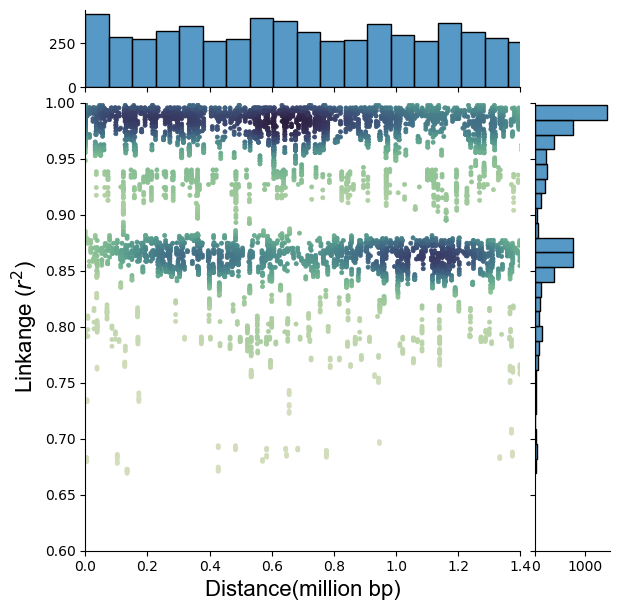

In [201]:
xy = np.vstack([ndist,nco])
z = gaussian_kde(xy)(xy)

norm=plt.Normalize(min(z),max(z))
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

g = sns.JointGrid(x=ndist, y=nco, xlim=(0, 14e5), ylim=(0.6, 1), marginal_ticks=True)
g.plot_joint(sns.scatterplot, cmap=cmap, c=z, edgecolor=None, marker='.')
g.plot_marginals(sns.histplot)
# g.plot_marginals(sns.kdeplot, color='black', zorder=10)
g.set_axis_labels('Distance(million bp)', 'Linkange ($r^2$)', fontname='Arial', fontsize=16)
_ = g.ax_joint.set_xticks(np.arange(0, 1.6e6, 0.2e6))
_ = g.ax_joint.set_xticklabels(np.arange(0, 16, 2) / 10)
plt.savefig('figures/linkage_dist_plot_scatter.svg')

Text(0, 0.5, 'Number of Alleles')

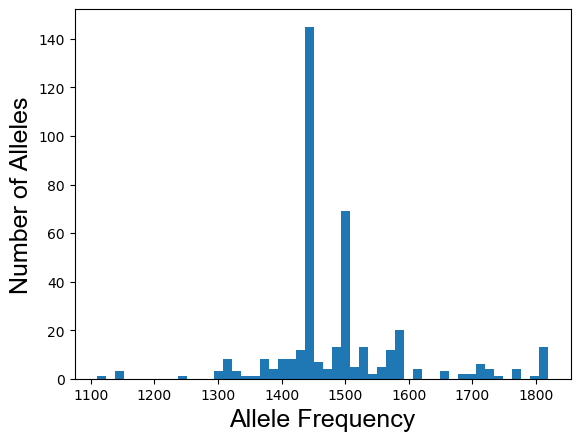

In [181]:
_ = plt.hist(sig_nodes[sig_nodes.AlleleFreq > 1000]['AlleleFreq'], bins=50)
plt.xlabel('Allele Frequency', fontname='Arial', fontsize=18)
plt.ylabel('Number of Alleles', fontname='Arial', fontsize=18)

# Mutation Pos

In [26]:
tch_sig = sig_nodes[sig_nodes['Annotations(sep=~~~)'].str.contains('USA300HOU|TCH')]

In [29]:
lt_to_pos = {}
for refseq in SeqIO.parse('data/genomes/TCH1516_full.gb', 'genbank'):
    for feats in refseq.features:
        try:
            lt = feats.qualifiers['locus_tag'][0]
        except KeyError:
            continue
        else:
            lt_to_pos.update({lt: np.mean([int(feats.location.start), int(feats.location.end)])})

In [30]:
def process_lt(row):
    mark = [i for i in row.split('~~~') if 'USA300' in i]
    if not mark:
        return
    lt = [i for i in mark[0].split(';') if 'USA300' in i]
    
    return lt_to_pos[lt[0]]

def process_intergenic(row):
    if 'USA300' in row:
        return
    start, end = row.split('_')[-1].split('-')
    return np.mean([int(start), int(end)])
mutation_positions = np.where(tch_sig['Annotations(sep=~~~)'].str.contains('USA300'),
         tch_sig['Annotations(sep=~~~)'].apply(process_lt),
         tch_sig['Annotations(sep=~~~)'].apply(process_intergenic))

In [32]:
chrl = 2872915 #length of the TCH chr

unique, counts = np.unique(mutation_positions, return_counts=True)
zer = np.zeros(chrl)
for u, c in zip(unique, counts):
    zer[int(u + 1)] = c

In [33]:
# set matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14
label_font = {'fontsize': 18}
text_font = {'fontsize': 12}
text_font_small = {'fontsize': 10}
tick_font = {'fontsize': 16}
color='#0d5b62'

Text(178026, 8, '$cap5e$ (D75Y)')

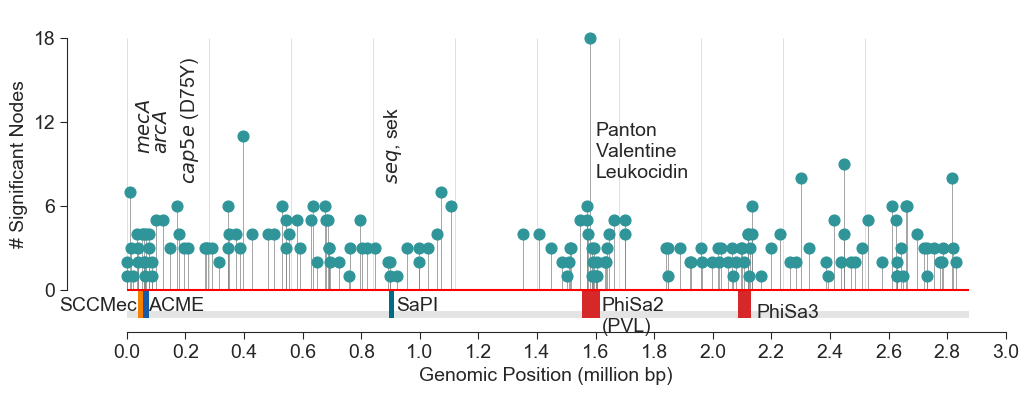

In [36]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12,4))
_ = [ax.vlines(n, 0, 18, linewidth=0.5, color='lightgray') for n in np.arange(0, 2.8e6, 2.8e5)]
_  = [ax.vlines(u, 0, c, color='gray', linewidth=0.5) for u, c in zip(unique, counts)]
ax.scatter(unique, counts, color='#2f9599', zorder=10, s=60)
ax.hlines(0, 0, chrl, color='red')
_ = ax.tick_params(which='both', axis='both', direction='out', reset=True,
                  top=False, right=False, length=5)
_ = ax.set_xticks(np.arange(0, 3.2e6, 2e5))
_ = ax.set_xticklabels(np.arange(0, 32, 2) / 10, fontsize=tick_font['fontsize'])
_ = ax.set_yticks(np.arange(0, 24, 6))
_ = ax.set_yticklabels(np.arange(0, 24, 6), fontsize=tick_font['fontsize'])
ax.set_ylim(-2, 20)

sns.despine(offset=10, trim=True)

ax.set_xlabel('Genomic Position (million bp)')
ax.set_ylabel('# Significant Nodes')
ax.add_patch(Rectangle((0, -2), chrl, 0.5, color='lightgray', alpha=0.6, linewidth=0, zorder=-1))

#PhiSa2(PVL)
ax.add_patch(Rectangle((1552553, -2),
                       1615806-1552553, 2,
                       color='#d62828', linewidth=0))
ax.text(1.62e6, -3, 'PhiSa2\n(PVL)')

#PhiSa3
ax.add_patch(Rectangle((2085696, -2),
                       2131498-2085696, 2,
                       color='#d62828', linewidth=0))
ax.text(2.15e6, -2, 'PhiSa3')

#scc mec
ax.add_patch(Rectangle((39127, -2),
                       54553-39127, 2,
                       color='#f77f00', linewidth=0))
ax.text(-230000, -1.5, 'SCCMec')
#acme
ax.add_patch(Rectangle((54553, -2),
                       75009-54553, 2,
                       color='#165baa', linewidth=0))
ax.text(0.71e5, -1.5, 'ACME')

#SaPI
ax.add_patch(Rectangle((894267, -2),
                       910305-894267, 2,
                       color='#006c84', linewidth=0))

ax.text(0.92e6, -1.5, 'SaPI')
ax.text(0.3e5, 10, '$mecA$', rotation=90) 
ax.text(0.9e5, 10, '$arcA$', rotation=90) 
ax.text(1.6e6, 8, 'Panton\nValentine\nLeukocidin')
ax.text(0.87e6, 8, '$seq$, sek', rotation=90)
ax.text(178026, 8, '$cap5e$ (D75Y)', rotation=90)
# plt.savefig('figures/Mutations_needleplot.svg')